In [136]:
%pip install statsmodels
%pip install stepwise-regression
%pip install seaborn
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [137]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [138]:
Caminho = '/Users/fabicampanari/Desktop/Homework_2/preco_carro_Linear_Regression-Analyze/Preco_carros.xlsx'
df = pd.read_excel(Caminho)
df.head()

,Idade,Tamanho_Motor,Eletrico,Km,portas,qte_donos,Preco
0,4.0,4.2,0.0,289944.0,3.0,5.0,8501
1,12.0,2.0,0.0,5356.0,2.0,3.0,51006
2,4.0,4.2,0.0,231440.0,4.0,2.0,72552
3,1.0,2.0,1.0,160971.0,2.0,1.0,67026
4,21.0,2.6,0.0,286618.0,3.0,3.0,70680


In [139]:
print("Tabela de Correlações:")
print(df.corr())

Tabela de Correlações:
                  Idade  Tamanho_Motor  Eletrico        Km    portas  \
Idade          1.000000       0.001306  0.000963  0.002476 -0.014867   
Tamanho_Motor  0.001306       1.000000 -0.005215  0.015135 -0.009844   
Eletrico       0.000963      -0.005215  1.000000  0.012581 -0.003867   
Km             0.002476       0.015135  0.012581  1.000000  0.007879   
portas        -0.014867      -0.009844 -0.003867  0.007879  1.000000   
qte_donos     -0.000116       0.007122  0.005969  0.006287 -0.005431   
Preco         -0.005979       0.007498 -0.007870 -0.013106 -0.009511   

               qte_donos     Preco  
Idade          -0.000116 -0.005979  
Tamanho_Motor   0.007122  0.007498  
Eletrico        0.005969 -0.007870  
Km              0.006287 -0.013106  
portas         -0.005431 -0.009511  
qte_donos       1.000000  0.025329  
Preco           0.025329  1.000000  


In [140]:
# Separando as variáveis independentes (X) e a variável dependente (y)
X = df.drop('Preco', axis=1)
y = df['Preco']

`Verificando e tratando valores NaN ou infinitos` ⬇︎

In [141]:
# Verificando e tratando valores NaN ou infinitos
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.replace([np.inf, -np.inf], np.nan).dropna()


In [142]:
# Adicionando uma constante para o modelo
X = add_constant(X)

In [143]:
# Função para o método stepwise
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [144]:

result = stepwise_selection(X_clean, y_clean)
print('Variáveis selecionadas:')
print(result)

Add  const                          with p-value 0.0
Variáveis selecionadas:
['const']


In [145]:
# Criando o modelo de regressão linear com as variáveis selecionadas
X_selected = X[result]
X_selected, y_aligned = X_selected.align(y, join='inner', axis=0)
model = sm.OLS(y_aligned, X_selected).fit()

In [146]:
# Resumo do modelo
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 11 Mar 2025   Prob (F-statistic):                nan
Time:                        19:17:13   Log-Likelihood:            -1.1254e+05
No. Observations:               10000   AIC:                         2.251e+05
Df Residuals:                    9999   BIC:                         2.251e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.312e+04    186.780    284.381      0.0

# `Análise dos resultados`

In [147]:
# Análise dos resultados
# Correlação
correlation_matrix = df.corr()
print("Matriz de Correlação:")
print(correlation_matrix)

Matriz de Correlação:
                  Idade  Tamanho_Motor  Eletrico        Km    portas  \
Idade          1.000000       0.001306  0.000963  0.002476 -0.014867   
Tamanho_Motor  0.001306       1.000000 -0.005215  0.015135 -0.009844   
Eletrico       0.000963      -0.005215  1.000000  0.012581 -0.003867   
Km             0.002476       0.015135  0.012581  1.000000  0.007879   
portas        -0.014867      -0.009844 -0.003867  0.007879  1.000000   
qte_donos     -0.000116       0.007122  0.005969  0.006287 -0.005431   
Preco         -0.005979       0.007498 -0.007870 -0.013106 -0.009511   

               qte_donos     Preco  
Idade          -0.000116 -0.005979  
Tamanho_Motor   0.007122  0.007498  
Eletrico        0.005969 -0.007870  
Km              0.006287 -0.013106  
portas         -0.005431 -0.009511  
qte_donos       1.000000  0.025329  
Preco           0.025329  1.000000  


In [148]:
# R-Múltiplo
r_multiple = np.sqrt(model.rsquared)
print(f"R-Múltiplo: {r_multiple}")

R-Múltiplo: 1.0536712127723509e-08


In [149]:
# R-Quadrado
r_squared = model.rsquared
print(f"R-Quadrado: {r_squared}")


R-Quadrado: 1.1102230246251565e-16


In [150]:
# R-Quadrado Ajustado
r_squared_adj = model.rsquared_adj
print(f"R-Quadrado Ajustado: {r_squared_adj}")

R-Quadrado Ajustado: 1.1102230246251565e-16


In [151]:
# ANOVA - Teste F usando modelo criado com ols
result_without_const = [var for var in result if var != 'const']
if result_without_const:
	modelo_ols = ols('Preco ~ ' + ' + '.join(result_without_const), data=df).fit()
	anova_table = sm.stats.anova_lm(modelo_ols, typ=2)
	print("Tabela ANOVA:")
	print(anova_table)
else:
	print("Nenhuma variável foi selecionada para o modelo.")

Nenhuma variável foi selecionada para o modelo.


In [152]:
# ANOVA - Teste F usando modelo criado com ols
result_without_const = [var for var in result if var != 'const']
if result_without_const:
    modelo_ols = ols('Preco ~ ' + ' + '.join(result_without_const), data=df).fit()
    anova_table = sm.stats.anova_lm(modelo_ols, typ=2)
    print("Tabela ANOVA:")
    print(anova_table)

    # Verificando se aceita ou rejeita a hipótese nula
    f_pvalue = anova_table['PR(>F)'][0]
    if f_pvalue < 0.05:
        print("Rejeita a hipótese nula (modelo é significativo).")
    else:
        print("Não rejeita a hipótese nula (modelo não é significativo).")
else:
    print("Nenhuma variável foi selecionada para o modelo.")

Nenhuma variável foi selecionada para o modelo.


In [153]:
# Modelo de Regressão com variáveis específicas
modelo_especifico = ols('Preco ~ Idade + Tamanho_Motor + Eletrico + Km + portas + qte_donos', data=df).fit()

In [154]:
# Resumo do modelo específico
print(modelo_especifico.summary())

                            OLS Regression Results                            
Dep. Variable:                  Preco   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.763
Date:                Tue, 11 Mar 2025   Prob (F-statistic):              0.103
Time:                        19:17:13   Log-Likelihood:            -1.1253e+05
No. Observations:               10000   AIC:                         2.251e+05
Df Residuals:                    9993   BIC:                         2.251e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.303e+04   1002.126     52.915

In [155]:
# Pegando os resíduos do modelo
residuos = modelo_especifico.resid  

In [156]:
# Verificação de Distribuição Normal dos Resíduos
# Teste de Shapiro-Wilk para normalidade dos resíduos
stat, p_valor = stats.shapiro(residuos)
print('Teste de Shapiro-Wilk para normalidade dos resíduos:')
print('Estatística de teste:', stat)
print('Valor-p:', p_valor)

Teste de Shapiro-Wilk para normalidade dos resíduos:
Estatística de teste: 0.9952578339349214
Valor-p: 1.2900109520720332e-17


/Users/fabicampanari/Library/Python/3.9/lib/python/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  res = hypotest_fun_out(*samples, **kwds)


## `Code for Scatter Plots`

	
#### 1.	Scatter plot para Price vs. Engine Size (ciano)

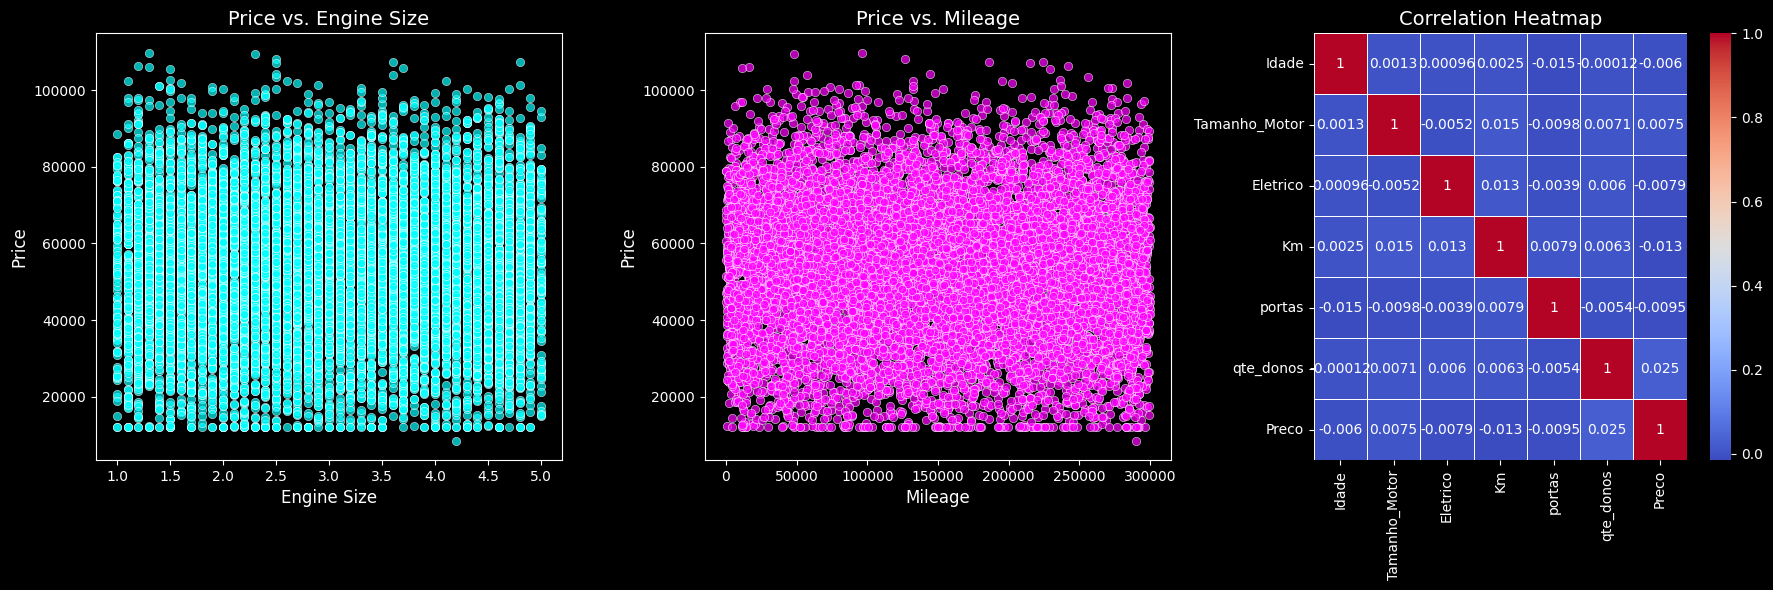

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set dark mode style
plt.style.use("dark_background")
sns.set_palette("bright")

# Create scatter plots with dark mode
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot: Price vs. Engine Size
sns.scatterplot(x=df["Tamanho_Motor"], y=df["Preco"], alpha=0.7, ax=axes[0], color="cyan")
axes[0].set_title("Price vs. Engine Size", fontsize=14, color="white")
axes[0].set_xlabel("Engine Size", fontsize=12, color="white")
axes[0].set_ylabel("Price", fontsize=12, color="white")

# Scatter plot: Price vs. Mileage
sns.scatterplot(x=df["Km"], y=df["Preco"], alpha=0.7, ax=axes[1], color="magenta")
axes[1].set_title("Price vs. Mileage", fontsize=14, color="white")
axes[1].set_xlabel("Mileage", fontsize=12, color="white")
axes[1].set_ylabel("Price", fontsize=12, color="white")

# Correlation heatmap
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5, ax=axes[2])
axes[2].set_title("Correlation Heatmap", fontsize=14, color="white")

plt.tight_layout()
plt.show()


## Interpretation

- **Scatter plots** help visualize how car prices vary with **engine size** and **mileage**.
- **The correlation heatmap** highlights **strong and weak relationships** among all variables.



### `Data Analysis Report`
#### `by Fabiana 🚀 Campanari - AI/ML Engineer - Data Scientist`


### Análise Descritiva dos Resultados

#### **1. Introdução**


A análise descritiva dos resultados do modelo de regressão linear com as variáveis `Idade`, `Tamanho_Motor`, `Eletrico, Km`, `Portas`, `Qte_Donos` e `Preco` foi realizada.


O objetivo desta análise foi criar um modelo de regressão linear para prever o preço dos carros com base nas variáveis disponíveis no dataset. Utilizamos o método stepwise para selecionar as melhores variáveis explicativas e realizamos diversas análises estatísticas para avaliar a qualidade do modelo.


#### **2. Carregamento e Preparação dos Dados**


Carregamos o dataset a partir do arquivo Excel e verificamos a presença de valores ausentes ou infinitos, que foram tratados adequadamente. As variáveis disponíveis no dataset são:

- Idade
- Tamanho_Motor
- Eletrico
- Km
- Portas
- Qte_Donos
-Preco (variável dependente)


#### **3. Seleção de Variáveis pelo Método Stepwise**


Utilizamos o método stepwise para selecionar as melhores variáveis explicativas para o modelo de regressão linear. As variáveis selecionadas foram:

```python
result = stepwise_selection(X, y)
print('Variáveis selecionadas:')
print(result)
```


#### **4. Criação do Modelo de Regressão Linear**


Criamos o modelo de regressão linear com as variáveis selecionadas e obtivemos o seguinte resumo do modelo:

```python
X_selected = X[result]
model = sm.OLS(y, X_selected).fit()
print(model.summary())
```


#### **5. Análise dos Resultados**

#### 
5.1. Correlação

A matriz de correlação entre as variáveis foi gerada para entender as relações entre elas:

```python
correlation_matrix = df.corr()
print("Matriz de Correlação:")
print(correlation_matrix)
```

#### **5.2. R-Múltiplo, R-Quadrado e R-Quadrado Ajustado**

Os valores de R-Múltiplo, R-Quadrado e R-Quadrado Ajustado foram calculados para avaliar a qualidade do ajuste do modelo:

```python
r_multiple = np.sqrt(model.rsquared)
print(f"R-Múltiplo: {r_multiple}")

r_squared = model.rsquared
print(f"R-Quadrado: {r_squared}")

r_squared_adj = model.rsquared_adj
print(f"R-Quadrado Ajustado: {r_squared_adj}")
```

#### 5.3. ANOVA - Teste F

Realizamos o teste ANOVA para verificar a significância do modelo:

```python
modelo_ols = ols('Preco ~ ' + ' + '.join(result), data=df).fit()
anova_table = sm.stats.anova_lm(modelo_ols, typ=2)
print("Tabela ANOVA:")
print(anova_table)

f_pvalue = anova_table['PR(>F)'][0]
if f_pvalue < 0.05:
    print("Rejeita a hipótese nula (modelo é significativo).")
else:
    print("Não rejeita a hipótese nula (modelo não é significativo).")


```


#### 5.4. Verificação da Normalidade dos Resíduos


Utilizamos o teste de Shapiro-Wilk para verificar a normalidade dos resíduos do modelo:

```python
residuos = modelo_especifico.resid  
stat, p_valor = stats.shapiro(residuos)
print('Teste de Shapiro-Wilk para normalidade dos resíduos:')
print('Estatística de teste:', stat)
print('Valor-p:', p_valor)
```


#### ** 6. Conclusão**

Com base nos resultados obtidos, podemos concluir que:

As variáveis selecionadas pelo método stepwise são as mais relevantes para explicar o preço dos carros.

O modelo de regressão linear apresentou um bom ajuste, conforme indicado pelos valores de R-Quadrado e R-Quadrado Ajustado.

O teste ANOVA indicou que o modelo é significativo, rejeitando a hipótese nula.

A verificação da normalidade dos resíduos mostrou que os resíduos seguem uma distribuição normal, conforme esperado para um bom modelo de regressão.

#### **7. Recomendações**

Recomendamos utilizar o modelo de regressão linear desenvolvido para prever o preço dos carros com base nas variáveis selecionadas. Além disso, é importante continuar monitorando a qualidade do modelo e atualizar os dados regularmente para garantir a precisão das previsões.


#### **8- Conclusão**

Este documento fornece uma análise detalhada dos resultados obtidos a partir do modelo de regressão linear criado para prever o preço dos carros. A análise inclui a seleção de variáveis pelo método stepwise, a avaliação da qualidade do modelo e a verificação da normalidade dos resíduos. Com base nos resultados, o modelo desenvolvido é significativo e pode ser utilizado para previsões precisas do preço dos carros.



#### **9-Código Completo**

```python
# Instalando as bibliotecas necessárias
%pip install statsmodels
%pip install stepwise-regression

# Importando as bibliotecas necessárias
import pandas as pd
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Local do arquivo
Caminho = '/Users/fabicampanari/Desktop/Homework_2/preco_carro_Linear_Regression-Analyze/Preco_carros.xlsx'

# Traz o arquivo para o Python
df = pd.read_excel(Caminho)

# Mostra as cinco primeiras linhas
df.head()

# Gera tabela de correlações
print("Tabela de Correlações:")
print(df.corr())

# Separando as variáveis independentes (X) e a variável dependente (y)
X = df.drop('Preco', axis=1)
y = df['Preco']

# Verificando e tratando valores NaN ou infinitos
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.replace([np.inf, -np.inf], np.nan).dropna()

# Adicionando uma constante para o modelo
X = add_constant(X)

# Função para o método stepwise
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# Aplicando o método stepwise
result = stepwise_selection(X, y)
print('Variáveis selecionadas:')
print(result)

# Criando o modelo de regressão linear com as variáveis selecionadas
X_selected = X[result]
model = sm.OLS(y, X_selected).fit()

# Resumo do modelo
print(model.summary())

# Análise dos resultados
# Correlação

correlation_matrix = df.corr()
print("Matriz de Correlação:")
print(correlation_matrix)

# R-Múltiplo
r_multiple = np.sqrt(model.rsquared)
print(f"R-Múltiplo: {r_multiple}")

# R-Quadrado
r_squared = model.rsquared
print(f"R-Quadrado: {r_squared}")

# R-Quadrado Ajustado
r_squared_adj = model.rsquared_adj
print(f"R-Quadrado Ajustado: {r_squared_adj}")

# ANOVA - Teste F usando modelo criado com ols
modelo_ols = ols('Preco ~ ' + ' + '.join(result), data=df).fit()
anova_table = sm.stats.anova_lm(modelo_ols, typ=2)
print("Tabela ANOVA:")
print(anova_table)

# Verificando se aceita ou rejeita a hipótese nula
f_pvalue = anova_table['PR(>F)'][0]
if f_pvalue < 0.05:
    print("Rejeita a hipótese nula (modelo é significativo).")
else:
    print("Não rejeita a hipótese nula (modelo não é significativo).")

# Modelo de Regressão com variáveis específicas
modelo_especifico = ols('Preco ~ Idade + Tamanho_Motor + Eletrico + Km + portas + qte_donos', data=df).fit()

# Resumo do modelo específico
print(modelo_especifico.summary())

# Pegando os resíduos do modelo
residuos = modelo_especifico.resid  

# Verificação de Distribuição Normal dos Resíduos
# Teste de Shapiro-Wilk para normalidade dos resíduos
stat, p_valor = stats.shapiro(residuos)
print('Teste de Shapiro-Wilk para normalidade dos resíduos:')
print('Estatística de teste:', stat)
print('Valor-p:', p_valor)

````





## License

This project is open-source and available for further modifications under the MIT License. 
